# Import statements

In [17]:
from requests import get
from bs4 import BeautifulSoup
from time import sleep
from time import time
from random import randint
import re
from warnings import warn
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# Rent

In [70]:
portland = {'name': 'Portland',
            'state': 'Oregon',
            'metro': 'portland',
            'metro_name': 'Portland',
            'dt_zip': '97204'}
sandiego = {'name': 'San Diego',
            'state': 'California',
            'metro': 'sandiego',
            'metro_name': 'San-Diego',
            'dt_zip': '92101'}
lajolla = {'name': 'La Jolla',
            'state': 'California',
            'metro': 'sandiego',
            'metro_name': 'San-Diego',
            'dt_zip': '92037'}
pasadena = {'name': 'Pasadena',
            'state': 'California',
            'metro': 'losangeles',
            'metro_name': 'Pasadena',
            'dt_zip': '91101'}
seattle = {'name': 'Seattle',
            'state': 'Washington',
            'metro': 'seattle',
            'metro_name': 'Seattle',
            'dt_zip': '98101'}

cities = [portland, sandiego, lajolla, pasadena, seattle]

In [12]:
def _get_all_posts(html_soup, name, metro, dt_zip, dist):
    #find the total number of posts to find the limit of the pagination
    results_num = html_soup.find('div', class_= 'search-legend')
    results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

    #each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
    pages = np.arange(0, results_total+1, 120)

    iterations = 0

    post_timing = []
    post_hoods = []
    post_title_texts = []
    bedroom_counts = []
    sqfts = []
    post_links = []
    post_prices = []

    for page in pages:

        #get request
        response = get("https://"
                       + metro
                       + ".craigslist.org/search/eby/apt?" 
                       + "s=" #the parameter for defining the page number 
                       + str(page) #the page number in the pages array from earlier
                       + "&hasPic=1"
                       + "&search_distance="
                       + dist
                       + "&postal="
                       + dt_zip
                       + "&min_price=500&min_bedrooms=1&max_bedrooms=2&availabilityMode=0")

        sleep(randint(1,5))

        #throw warning for status codes that are not 200
        if response.status_code != 200:
            warn('Request: {}; Status code: {}'.format(requests, response.status_code))

        #define the html text
        page_html = BeautifulSoup(response.text, 'html.parser')

        #define the posts
        posts = html_soup.find_all('li', class_= 'result-row')

        #extract data item-wise
        for post in posts:

            if post.find('span', class_ = 'result-hood') is not None:

                #posting date
                #grab the datetime element 0 for date and 1 for time
                post_datetime = post.find('time', class_= 'result-date')['datetime']
                post_timing.append(post_datetime)

                #neighborhoods
                post_hood = post.find('span', class_= 'result-hood').text
                post_hoods.append(post_hood)

                #title text
                post_title = post.find('a', class_='result-title hdrlnk')
                post_title_text = post_title.text
                post_title_texts.append(post_title_text)

                #post link
                post_link = post_title['href']
                post_links.append(post_link)

                #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
                post_price = int(post.a.text.strip().replace("$", "")) 
                post_prices.append(post_price)

                if post.find('span', class_ = 'housing') is not None:

                    #if the first element is accidentally square footage
                    if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:

                        #make bedroom nan
                        bedroom_count = np.nan
                        bedroom_counts.append(bedroom_count)

                        #make sqft the first element
                        sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                        sqfts.append(sqft)

                    #if the length of the housing details element is more than 2
                    elif len(post.find('span', class_ = 'housing').text.split()) > 2:

                        #therefore element 0 will be bedroom count
                        bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                        bedroom_counts.append(bedroom_count)

                        #and sqft will be number 3, so set these here and append
                        sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                        sqfts.append(sqft)

                    #if there is num bedrooms but no sqft
                    elif len(post.find('span', class_ = 'housing').text.split()) == 2:

                        #therefore element 0 will be bedroom count
                        bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                        bedroom_counts.append(bedroom_count)

                        #and sqft will be number 3, so set these here and append
                        sqft = np.nan
                        sqfts.append(sqft)                    

                    else:
                        bedroom_count = np.nan
                        bedroom_counts.append(bedroom_count)

                        sqft = np.nan
                        sqfts.append(sqft)

                #if none of those conditions catch, make bedroom nan, this won't be needed    
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)

                    sqft = np.nan
                    sqfts.append(sqft)
                #    bedroom_counts.append(bedroom_count)

                #    sqft = np.nan
                #    sqfts.append(sqft)

        iterations += 1
        print("Page " + str(iterations) + " in " + name + " scraped successfully!")

    print("\n")

    print("Scrape complete for " + name + "!")
    
    post_df = pd.DataFrame({'name': name,
                            'posted': post_timing,
                            'neighborhood': post_hoods,
                            'post title': post_title_texts,
                            'number bedrooms': bedroom_counts,
                            'sqft': sqfts,
                            'URL': post_links,
                            'price': post_prices})
    
    return post_df

In [14]:
def _get_craigslist_city(city_dict, dist):
    name = city_dict['name']
    metro = city_dict['metro']
    dt_zip = city_dict['dt_zip']
    
    response = get("https://"
                       + metro
                       + ".craigslist.org/search/eby/apt?"
                       + "&hasPic=1"
                       + "&search_distance="
                       + dist
                       + "&postal="
                       + dt_zip
                       + "&min_price=500&min_bedrooms=1&max_bedrooms=2&availabilityMode=0")
    
    sleep(randint(1,5))
    
    html_soup = BeautifulSoup(response.text, 'html.parser')
    
    post_df = _get_all_posts(html_soup, name, metro, dt_zip, dist)
    
    return post_df

In [15]:
def get_craigslist(city_ls, dist):
    df_ls = []
    for city in city_ls:
        city_df = _get_craigslist_city(city, dist)
        
        df_ls.append(city_df)
    
    df = pd.concat(df_ls)
    
    return df

In [16]:
rent = get_craigslist(cities, '5')

Page 1 in Portland scraped successfully!
Page 2 in Portland scraped successfully!
Page 3 in Portland scraped successfully!
Page 4 in Portland scraped successfully!
Page 5 in Portland scraped successfully!
Page 6 in Portland scraped successfully!
Page 7 in Portland scraped successfully!
Page 8 in Portland scraped successfully!
Page 9 in Portland scraped successfully!
Page 10 in Portland scraped successfully!
Page 11 in Portland scraped successfully!
Page 12 in Portland scraped successfully!
Page 13 in Portland scraped successfully!
Page 14 in Portland scraped successfully!
Page 15 in Portland scraped successfully!
Page 16 in Portland scraped successfully!
Page 17 in Portland scraped successfully!
Page 18 in Portland scraped successfully!
Page 19 in Portland scraped successfully!
Page 20 in Portland scraped successfully!
Page 21 in Portland scraped successfully!
Page 22 in Portland scraped successfully!
Page 23 in Portland scraped successfully!


Scrape complete for Portland!
Page 1 in S

In [18]:
rent

,name,posted,neighborhood,post title,number bedrooms,sqft,URL,price
0,Portland,2020-02-29 09:48,"(SW Portland, W Burnside, Downtown, Waterfront)",One Bedroom Close to the Waterfront | 6-Weeks ...,1,564.0,https://portland.craigslist.org/mlt/apa/d/port...,1595
1,Portland,2020-02-29 15:40,(Portland),Affordable One Bedroom with Ample Built in Sto...,1,543.0,https://portland.craigslist.org/mlt/apa/d/port...,1320
2,Portland,2020-03-01 16:00,"(SW Portland, W Burnside, Downtown, Waterfront)",One Bedroom Close to the Waterfront | 6-Weeks ...,1,564.0,https://portland.craigslist.org/mlt/apa/d/port...,1595
3,Portland,2020-03-02 10:06,(Portland),Beautiful BMR One Bedroom with Ample Built in ...,1,543.0,https://portland.craigslist.org/mlt/apa/d/port...,1320
4,Portland,2020-03-02 13:18,"(SW Portland, Downtown, Waterfront, W Burnside)",Large One-Bedroom in the Heart of Downtown! 6 ...,1,594.0,https://portland.craigslist.org/mlt/apa/d/port...,1595
...,...,...,...,...,...,...,...,...
2751,Seattle,2020-03-06 14:48,(1900 1st Ave),"Coming This April: Spacious, Open Den, Sunny 1...",1,714.0,https://seattle.craigslist.org/see/apa/d/seatt...,2595
2752,Seattle,2020-03-06 15:24,(Downtown/Pike Place/belltown),"Hardwood Floors throughout Living Areas, Overs...",1,691.0,https://seattle.craigslist.org/see/apa/d/seatt...,2585
2753,Seattle,2020-03-07 01:15,(Seattle),$3400/1br - Brand new luxury 1b1b +Den Nexus 1...,1,673.0,https://seattle.craigslist.org/see/apa/d/seatt...,3400
2754,Seattle,2020-03-07 09:01,"(1823 Minor Ave Seattle, WA)",PENTHOUSE - BEST VIEWS IN THE BUILDING!! CONCE...,2,1535.0,https://seattle.craigslist.org/see/apa/d/seatt...,6130


In [26]:
rent['number bedrooms'] = rent['number bedrooms'].astype(int)

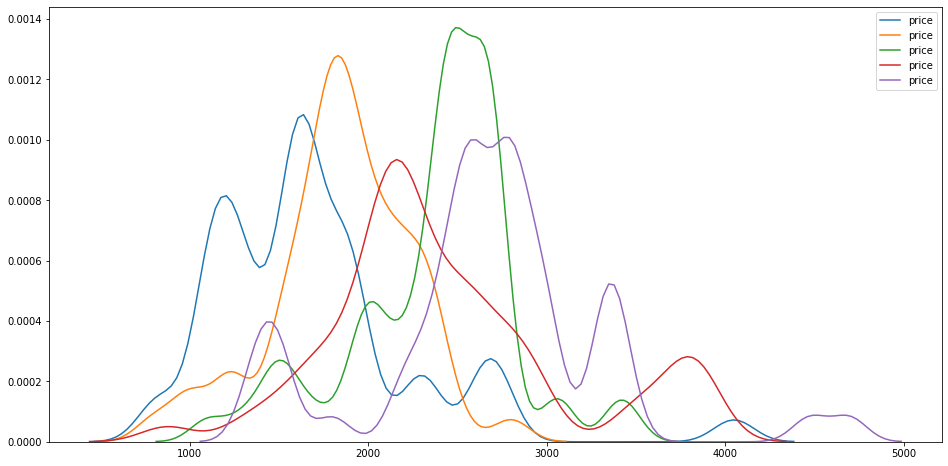

In [27]:
plt.figure(figsize=(16,8))
label = 'Portland'
sns.kdeplot(rent.loc[(rent.name == 'Portland') & (rent.price <= 6000) & (rent['number bedrooms'] == 1)].price)
label = 'La Jolla'
sns.kdeplot(rent.loc[(rent.name == 'La Jolla') & (rent.price <= 6000) & (rent['number bedrooms'] == 1)].price)
label = 'San Diego'
sns.kdeplot(rent.loc[(rent.name == 'San Diego') & (rent.price <= 6000) & (rent['number bedrooms'] == 1)].price)
label = 'Pasadena'
sns.kdeplot(rent.loc[(rent.name == 'Pasadena') & (rent.price <= 6000) & (rent['number bedrooms'] == 1)].price)
label = 'Seattle'
sns.kdeplot(rent.loc[(rent.name == 'Seattle') & (rent.price <= 6000) & (rent['number bedrooms'] == 1)].price)
plt.show()

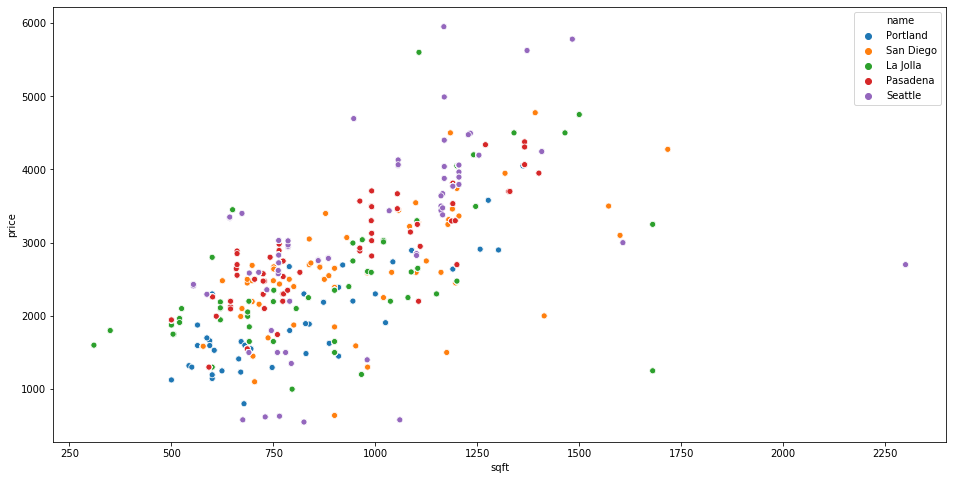

In [32]:
plt.figure(figsize=(16,8))
sns.scatterplot(x = 'sqft',
                y = 'price',
                hue = 'name',
                data = rent.loc[rent.price <= 6000])

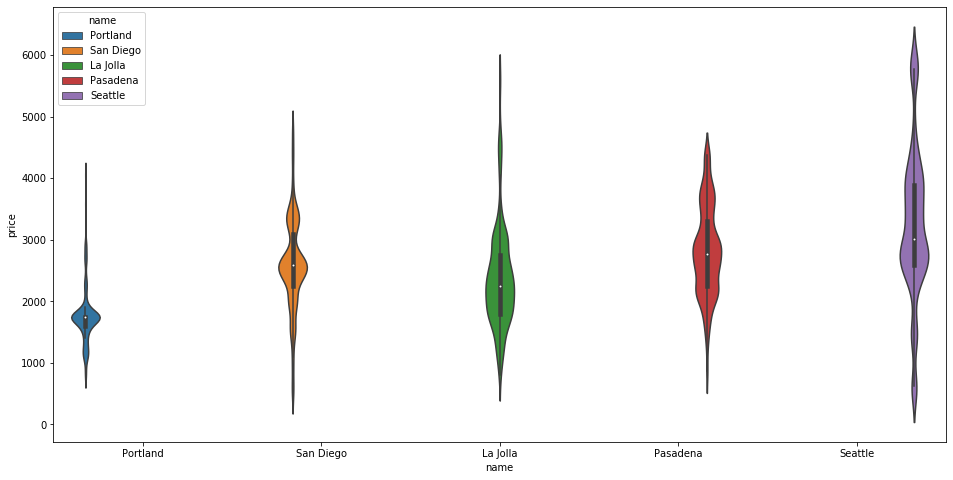

In [34]:
plt.figure(figsize=(16,8))
sns.violinplot(x = 'name',
                y = 'price',
                hue = 'name',
                data = rent.loc[rent.price <= 6000])

# Other Expenses

In [36]:
response = get('https://www.payscale.com/cost-of-living-calculator/Oregon-Portland')

In [37]:
html_soup = BeautifulSoup(response.text, 'html.parser')

In [91]:
groceries = html_soup.find_all('div', class_='itemized__blurb')[1].text
if 'higher' in groceries:
    groceries = (1 + np.float64(re.sub('\D', '', groceries))/100 - 1.15)/1.15
else:
    groceries = (1 - np.float64(re.sub('\D', '', groceries))/100 - 1.15)/1.15

In [92]:
groceries

0.0

In [69]:
re.sub('\D', '', html_soup.find_all('div', class_='itemized__item')[0].find('div', class_='itemized__item-value').text)

'620783'

In [103]:
item_ls = html_soup.find_all('div', class_='city__chart-container')

In [100]:
print(html_soup.prettify())

<!DOCTYPE html>
<html lang="en">
 <head>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <meta class="next-head" content="width=device-width,minimum-scale=1,initial-scale=1" name="viewport"/>
  <meta charset="utf-8" class="next-head"/>
  <title class="next-head">
   Cost of Living in Portland, OR | PayScale
  </title>
  <meta class="next-head" content="Portland, Oregon’s cost of living is 29% higher than the national average. Compare cost of living in Portland with factors like salaries, housing expenses, groceries, utilities and more." name="description"/>
  <meta class="next-head" content="AJLjRfeS-icSJpHmRpKDHKPieKoFc1HwZ5nA" name="csrf"/>
  <link class="next-head" href="https://payscale.com/cost-of-living-calculator/Oregon-Portland" rel="canonical"/>
  <link href="https://cdn-payscale.com/content/favicon/favicon-32x32.png" rel="icon" sizes="32x32" type="image/png"/>
  <script class="next-head" src="//cdn-payscale.com/content/privacy-ux/1.4.1/cookies.min.js

In [78]:
item_names = []
item_costs = []
for item in item_ls:
    item_names.append(item.find('div', class_='itemized__item-title').text.strip())
    item_costs.append(np.float64(re.sub('[^\d|\.]', '', item.find('div', class_='itemized__item-value').text)))
    
{item_names[i]: item_costs[i] for i in range(len(item_names))}

{'Median Home Price': 620783.0,
 'Median Rent': 1945.0,
 'Energy Bill': 130.77,
 'Phone Bill': 139.4,
 'Gas': 2.78,
 'Loaf of Bread': 3.84,
 'Gallon of Milk': 2.23,
 'Carton of Eggs': 2.09,
 'Bunch of Bananas': 3.87,
 'Hamburger': 4.88,
 "Doctor's Visit": 118.57,
 'Dentist Visit': 101.86,
 'Optometrist Visit': 111.11,
 'Rx Drug': 472.31,
 'Veterinary Visit': 60.53}

In [ ]:
def _get_all_costs(html_soup, name, metro_name, state, dt_zip, dist):
    response = get('https://www.payscale.com/cost-of-living-calculator/'
                   + state
                   + '-'
                   + metro_name)
    
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
    
    sleep(randint(1,5))
    
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    item_names = []
    item_costs = []
    
    groceries = page_html.find_all('div', class_='itemized__blurb')[1].text
    
    if 'higher' in groceries:
        groceries = (1 + np.float64(re.sub('\D', '', groceries))/100 - 1.15)/1.15
    else:
        groceries = (1 - np.float64(re.sub('\D', '', groceries))/100 - 1.15)/1.15
    
    item_names.append('percent_change_groceries')
    item_costs.append(groceries)
    
    items_ls = page_html.find_all('div', class_='itemized__item')
    
    #extract data item-wise
    for item in item_ls:
        
        #item name
        item_names.append(item.find('div', class_='itemized__item-title').text)
        
        #item cost
        item_costs.append(re.sub('[^\d|\.]', '', item.find('div', class_='itemized__item-value').text))
    
    costs = {item_names[i]: item_costs[i] for i in range(len(item_names))}
    
    print("\n")

    print("Scrape complete for " + name + "!")
    
    post_df = pd.DataFrame({'name': name,
                            'posted': post_timing,
                            'neighborhood': post_hoods,
                            'post title': post_title_texts,
                            'number bedrooms': bedroom_counts,
                            'sqft': sqfts,
                            'URL': post_links,
                            'price': post_prices})
    
    return post_df